In [1]:
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# for data processing for Tensorflow
import numpy as np
# for saving Tensorflow checkpoints
import os
# for loading and manipulating data
import pandas as pd
# for neural networks
import tensorflow as tf

review.json is 5.2 GB uncompressed with 6685900 lines corresponding to reviews and review metadata.  
It is too large to load completely into memory so I will load pieces of it as needed (pandas chunksize argument.)

# Filtering Data

In [2]:
# %%time #4min 38s
# # load data using chunksize option
# df_chunks = pd.read_json('../data/yelp_dataset/review.json', lines=True, chunksize=400000)

# # list to hold chunks after querying
# chunks = [chunk[(chunk.stars == 5.0) & (chunk.useful > 0)] for chunk in df_chunks]

# # dataframe of useful 5-star reviews
# df = pd.concat(chunks)

# # save csv for faster loading in the future
# df.to_csv('../data/useful_reviews.csv')

In [3]:
%%time
# load data from csv for a faster start
df = pd.read_csv('../data/useful_reviews.csv', index_col=0)

C:\Users\K\Miniconda3\envs\tf-gpu-cuda10\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 11.5 s


In [4]:
# add <SOR> and <EOR> tokens to delimit reviews
df.text = df.text.apply(lambda x: '<SOR>' + x + '<EOR>')
df_copy = df.copy()

In [36]:
# minimum number of useful votes to include
n = 60

# number of reviews in subset
print(df_copy[df_copy.useful >= n].shape[0])

# number of characters in subset
print(len(df_copy[df_copy.useful >= n].text.str.cat()))

# block of text to serve as model training data
text = df_copy[df_copy.useful >= n].text.str.cat()

# dataframe to allow for eda plots
df = df_copy[df_copy.useful >= n]

# subset for eda plotting about comment characteristics
text_length = df.text.str.len()

598
946699


1194239 reviews have been voted useful.  
591242 reviews have more than 1 useful vote.  
335812 reviews have more than 2 useful votes.  
211232 reviews have more than 3 useful votes.  
31020 reviews have more than 10 useful votes.  
5696 reviews have 25+ useful votes.*  
3733 reviews have 30+ useful votes.  
1812 reviews have 40+ useful votes.  
*For reduced computation time during this prototyping phase, I will use this reduced data set.

# EDA

Comments with at least 30 useful votes have a mean length of 1458 characters.  
Comments with at least 25 useful votes have a mean length of 1399 characters.

In [6]:
text_length.describe()

count    5696.000000
mean     1399.324965
std      1011.935319
min        66.000000
25%       648.750000
50%      1160.500000
75%      1869.250000
max      5010.000000
Name: text, dtype: float64

In [7]:
df.text[text_length == 66].values # shortest review. user and business id are hashed and requiring merging a different json.

array(['<SOR>I received the product as expected and on time.  Thanks!<EOR>'],
      dtype=object)

In [8]:
df.text[text_length == 5010].values # longest reviews. user and business id are hashed and requiring merging a different json.

array(['<SOR>The ratings are not a lie and I have a new Top 3 favourite spot in Toronto. There\'s a lot of great things about Richmond Station.. but if there is one takeaway from my review, let it be this.  If you want a phenomenal meal, ask specifically for the chef pass and the chef tasting menu.  Not only is it a feast for your taste buds and eyes... it is a feast of all senses.  \n\nFrom the outside, you wouldnt think automatically a restaurant of this calibre and space would be hiding behind a simple window golden font of Richmond Station and a tiny signage with  simple words of \'Restaurant\'.  If you peered in, you\'d see an overflowing amount of people enjoying a lot of interesting dishes.  You\'ll also notice a lot of people coming in to only be sadly turned away.  \n\nThe space is warm and welcoming... there\'s no pretentious airs here.  It\'s quite different from my other 2 favourite higher end spots (Buca and Grey Gardens).  The atmosphere here is relaxed and if anything, m

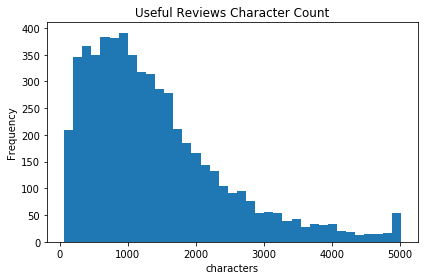

In [9]:
# plot distribution of character counts in useful reviews subset
text_length.plot(kind='hist', bins='fd', title='Useful Reviews Character Count')
plt.xlabel('characters')
plt.tight_layout()
plt.savefig('../img/useful_reviews_char_count.png')
plt.show()

# Data Pre-processing

In [10]:
# function that turns a sequence of length 100+1 into an input chunk (first 100 char) and target chunk (last 100 char).
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [37]:
# The unique characters in the file / number of output layer nodes.
vocab = sorted(set(text))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# converting text data into indices
text_as_int = np.array([char2idx[c] for c in text])

In [38]:
# create training and validation folds
text_as_int_tr = text_as_int[:int(text_as_int.shape[0]*.9)]
text_as_int_val = text_as_int[int(text_as_int.shape[0]*.1):]

In [39]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# options for saving checkpoints
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Model Architectures

## Wednesday Model / LSTM w Dropout

In [40]:
# The maximum length sentence we want for a single input in characters
seq_length = 256

# number of samples given sequence length
examples_per_epoch = len(text_as_int_tr)//(seq_length+1)

# Create training, validation examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int_tr)
char_dataset_val = tf.data.Dataset.from_tensor_slices(text_as_int_val)

# combine consecutive elements of a data set into batches
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
sequences_val = char_dataset_val.batch(seq_length+1, drop_remainder=True)

In [41]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)
dataset_val = sequences.map(split_input_target)

# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [42]:
# loss function for neural net
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [52]:
# Simple GRU based on https://www.tensorflow.org/tutorials/text/text_generation
def build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
      # embedding layer. ?? what does it do ??
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
      # LSTM layer. return full sequence to output layer
    tf.keras.layers.LSTM(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.LSTM(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True,
                        stateful=True
                        ),
      # output is a matrix of shape(seq length, vocab size)
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [53]:
# function to generate strings of variable length
def generate_text(model, start_string, num_generate=1000, temperature=1.0):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = num_generate

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = temperature

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
    
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [54]:
# more efficient than adding layers method
model_lstm = build_model_lstm(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
# print model architecture table
model_lstm.summary()
# model needs to be compiled
model_lstm.compile(optimizer='adam', loss=loss)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (32, None, 256)           31744     
_________________________________________________________________
lstm_11 (LSTM)               (32, None, 1024)          5246976   
_________________________________________________________________
lstm_12 (LSTM)               (32, None, 1024)          8392704   
_________________________________________________________________
dense_5 (Dense)              (32, None, 124)           127100    
Total params: 13,798,524
Trainable params: 13,798,524
Non-trainable params: 0
_________________________________________________________________


In [55]:
# model_lstm.load_weights('../training_checkpoints/lstm_training_checkpoints\\ckpt_15')

In [ ]:
# number of passes over the data
EPOCHS=50
# fit model
history = model_lstm.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], validation_data=dataset_val)

Train for 103 steps, validate for 3315 steps
Epoch 1/50
 42/103 [===========>..................] - ETA: 7:05 - loss: 3.3635

# Monday Model / SimpleGRU
Train for 842 steps  
Epoch 1/30  
842/842 [==============================] - 856s 1s/step - loss: 1.9921  
Epoch 2/30  
842/842 [==============================] - 858s 1s/step - loss: 1.4514  
Epoch 3/30  
842/842 [==============================] - 860s 1s/step - loss: 1.3572  
Epoch 4/30  
842/842 [==============================] - 836s 993ms/step - loss: 1.3080  
Epoch 5/30  
842/842 [==============================] - 831s 987ms/step - loss: 1.2742  
Epoch 6/30  
842/842 [==============================] - 837s 994ms/step - loss: 1.2484  
Epoch 7/30  
842/842 [==============================] - 830s 986ms/step - loss: 1.2276  
Epoch 8/30  
842/842 [==============================] - 831s 987ms/step - loss: 1.2109  
Epoch 9/30  
842/842 [==============================] - 831s 986ms/step - loss: 1.1973  
Epoch 10/30  
842/842 [==============================] - 825s 980ms/step - loss: 1.1865  
Epoch 11/30  
842/842 [==============================] - 822s 976ms/step - loss: 1.1778  
Epoch 12/30  
842/842 [==============================] - 820s 974ms/step - loss: 1.1712  
Epoch 13/30  
842/842 [==============================] - 817s 970ms/step - loss: 1.1671  
Epoch 14/30  
842/842 [==============================] - 816s 969ms/step - loss: 1.1644  
Epoch 15/30  
842/842 [==============================] - 808s 960ms/step - loss: 1.1634  
Epoch 16/30  
842/842 [==============================] - 818s 971ms/step - loss: 1.1635  
Epoch 17/30  
842/842 [==============================] - 808s 959ms/step - loss: 1.1659  
Epoch 18/30  
842/842 [==============================] - 810s 962ms/step - loss: 1.1708  
Epoch 19/30  
842/842 [==============================] - 813s 965ms/step - loss: 1.1781  
Epoch 20/30  
842/842 [==============================] - 809s 961ms/step - loss: 1.1855  
Epoch 21/30  
842/842 [==============================] - 807s 959ms/step - loss: 1.2153  
Epoch 22/30  
842/842 [==============================] - 807s 959ms/step - loss: 1.2153  
Epoch 23/30  
842/842 [==============================] - 808s 959ms/step - loss: 1.2193  
Epoch 24/30  
842/842 [==============================] - 806s 957ms/step - loss: 1.2577  
Epoch 25/30  
842/842 [==============================] - 814s 967ms/step - loss: 1.4293  
Epoch 26/30  
842/842 [==============================] - 803s 954ms/step - loss: 1.5127  
Epoch 27/30  
842/842 [==============================] - 804s 955ms/step - loss: 2.0795  
Epoch 28/30  
842/842 [==============================] - 802s 952ms/step - loss: 2.0716  
Epoch 29/30  
842/842 [==============================] - 801s 951ms/step - loss: 2.0330  
Epoch 30/30  
842/842 [==============================] - 794s 943ms/step - loss: 2.0158  

## Generating Text

### Checkpoint 15 (lowest training loss)

In [50]:
# rebuild model with batch size = 1
model_simplegru = build_model_simplegru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_simplegru.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_15')
# ?? ??
model_simplegru.build(tf.TensorShape([1, None]))
# print model architecture table
model_simplegru.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (1, None, 256)            37120     
_________________________________________________________________
gru_15 (GRU)                 (1, None, 1024)           3938304   
_________________________________________________________________
dense_11 (Dense)             (1, None, 145)            148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.2))

ROMEO: It is a fantastic deal of a bar. They have a standard steak and chips and the staff is super clean.  The portions are super friendly and helpful.  It is so much flavorful and friendly. The service was excellent and the perfect size and the staff is very friendly and helpful. The service was excellent and the price was a bit too busy and the staff is friendly and helpful. We were able to eat the chance of such a great store that was a little spot and the complimentary seafood is the best thing I have ever had.  We were able to see the door and the staff is very friendly and helpful. The chicken was the same thing I was in the way to go on the strip and the staff is very friendly and helpful.  I was so happy this place is a fast and family of a big deal that I have enjoyed this store. I was so happy to have the space for my life story to the strip and the staff is very friendly and helpful. We were told they were a bit disappointed. I was so happy to have this incredible service and friendly staff. The staff is friendly and helpful. I was in a small store and they were absolutely perfect. It was the same time we were able to see the chicken fingers and the staff is very friendly and 

print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.4))

ROMEO: Ambiance Works Here was the perfect dessert section and I was impressed with the service and the staff has a small booth that remember the stuffed combo me to the small side and the presentation is ready to meet your seat. The main dining room is pretty awesome and the staff is superb.

We were walking around and completed the show and the staff is very professional and professional and has a chilled crowd stores for the star.

The service was warm and so amazing. I could not have to say that the bar is so amazing and I was confident in the middle of the day after the staff here is so rich. So good.  So good and experienced that they were on the plate with a ton of chili sauce and the buttery sauce. I loved the show at the country. The dessert was the perfect size and the staff is very nice and friendly. The staff is very friendly and friendly. The parking is spacious and complementary stuffed with bone marrow and salsa bars. The service was great. I was amazed by the wait was a bit different and were a bit step of the space that will be a little bit of chopped cream and the strawberry short rib eye was so good! It was so good! The server was so friendly and helpful.  The chicken w

print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.6))

ROMEO: It was so damn good with the service though. The portion size was so good the stuff also have the best poke locations. There are taxi salad and the small bowl chocolate white chocolate). I have tried the same thing and the property is quite reasonable. I was the only one I already know that this was a solid 5 star review. I've been here to be a back shopping and shared this restaurant which was my favorite. There are two types of bold pork soup dusted with ginger salad and chips and the store is so simple with the toppings as the onion rings and she referred me to their show at the two locations.  The staff is very friendly and served in a clear piece of sweet and small masalation.  

The picture is so sweet and the last walnut is off the menu. There was a small side of cheese and cheese cake with a side of fries and buttery seafood burritos.  The signature dressing is pretty cold. I was so pleasantly surprised when I come to Vegas for me! Now it was the summer project which was very friendly and is so soft, and the performers had the spices of the strawberry salad and the owner San Francisco really check out a few minutes to complete our music could be. I was a little too much of 

print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.8))

ROMEO: You don't want to be a mixture of the costumes to be super light.  There's no east of the Phoenix's on our visit and I haven't tried a restaurant and the strangers wasn't not sports books pretty for the kind service.  I'm glad she remember to take your time and stuffed well whisker, it's everything that has a full bar.  Come later too.  I thought it was a bit pink and tuna.  In fact, one is the price of the turtless of fresh none because the soft modest television. I've stayed in a taste buds and sushi sassion stores in the pulled for discount with during their lifetime.  I treated the staff review after a matter of mines. They have had tart chocolate and seaf the business that you can't find a few days. I wish the best explanation progress I drop everything during the building! I decided to go with the FAVE and that the restaurant is clean and outstanding. The customer service here is pretty extremely integrasted on the side note.  Once I got out of resemble car back and saw the Chicken Tuna.  My last selection had to keep it now that I have the Child Taco in the place a time stapping in a fab.

I have to say that it wasn't first and was close and recently been an extra bars. It's

print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=1))

ROMEO: No french science...I'd like to see they have gravy beart's for a taste of it, after 4pm.
We enjoyed the BCAO  Unlimited entertainment
Im HATE pastas a weite takarian additional different family. It is something like this!)  If someone are not a thought, and you can dumped over the sleek  redar chefs will speet, but my wife ordered the degree meatballs. Basic and not tave very much. We were since to come to Vegas to take ice cream for her so filling out.
This is not much time, this is not a drink or trip to Mysolvts and lovely events because everyone appearant that's actually filling.

When compares to the dish!

Na has the best decision to enll in hala, rapposed bacon and grilled http://www.yelp. Fairly relatives 1 small steak!  I was so excited, I've been to Star was the best thing I did get a DAYM I want and need to take a people in Las Vegas's anyone who ordered my sister are pulled the creamment and tor place had a little bite. I was so healthy first and very fantastic! We sat outsions together to instantly, but skip this again near the estimated journey to the textures though it was boring. Holy toaste dressing is going to comertice on the menu. Loved the four encozy and sour

print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=1.2))

ROMEO: It Was Good Nest search!  Rigit.
I Had To Whis Still was it are still butway on eight stoney.  You aren't ve Giver Exerect long d eachapho and Wastolvelf) taco t it.  
Quite good, as we have four incisions ready for ong place, and coupons in Vegas under folks. Aside from Amerlookfair to make sure I found   all day shaking with chicken drig!
What she right so packing). Really technology. I keepy also figether Vegas, or just need to try their $40 bags , hause FLoors and LA testod my name for the ohas
#Celd CT Faki2 Hrughtnmets
2) HeActhe Kobe step $7.75. registicn edecaike I have experienced his host didnjurfer vian.
Sure to sed Sandwich:

~ "Lwnt treatment my nearbel to "dedication" our local. You gefially appreciated me restracher, und udmag, my iPisto guo"slightly bustbold seafoodtome" polishing specials.  And the texis, holy duisket - truffle portions.

As If skillet for the Curry!
I'm glad I) here this showers threw to boast

Will be back incorperfall tripping on iced /regow:
ot's hearty kit of cheese stuffed a 2 was fresh a-goalOMUb 18 holla!) Sh ramble on no churgeous!
Wow, I askedpe and built about 195-2.5 mile. The hustang also "Broadview."
- Timplem and hyed DAY!!! Be caugh

### Checkpoint 30 (last checkpoint)

In [57]:
# rebuild model with batch size = 1
model_simplegru = build_model_simplegru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_simplegru.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_30')
# ?? ??
model_simplegru.build(tf.TensorShape([1, None]))
# print model architecture table
model_simplegru.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (1, None, 256)            37120     
_________________________________________________________________
gru_16 (GRU)                 (1, None, 1024)           3938304   
_________________________________________________________________
dense_12 (Dense)             (1, None, 145)            148625    
Total params: 4,124,049
Trainable params: 4,124,049
Non-trainable params: 0
_________________________________________________________________


In [82]:
print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=.2))

ROMEO: DON The macan was so med in the server the but the the bes a really and the make to cortarie and the some to ster that the back the and the make the sor the stark the salad the but the was the is and the been and a so as a could ben and the some the some spere and the staff a decided to buse with the bean and the straing and in the sure so was a so park and the some the sum the back offer the starthe the some so for some are the some the sure some the sure sizzer and have a great and was the be and the server the chooke and the sauce so the but the have a dreat the service spection and the be and the some shopper and the server and server and the server some to ster the bes to the some a lover the some shopper seate that the side the some some some shopper shay and the cances and the service stall and she were and the some shope startare and the presh the sould bet in the sour she chat the server the start a st the was a so be the start with the sould the for the shop the wher h

In [33]:
print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=.4))

ROMEO: OND Cher mage a from the same for mosten in and really and the price. The and had and she cork the some some and the coun the was the make and crunt of the seat the so stare with fran sot a grally come somet be out like a brizalk a fers whall a did and the chent and striped like the side some and a great at but for som the somp specided the soce was a love staffer and the beat the buck and the soued have and stal don the mad in a really a did of the food the seat the sauche so I pork and the bel of sall on the the sure was so mouthe Vegas.  I had the stopped to the in the want ad and a super in the suce are and was the could and wark the star ther the menu and the so my feat the stars. 

I harded and the per and and had the sauce and the not sup and a but the sushe is ar and shor the cions and I was geet and that the bas a proge the stand tort whan the side for the my have and the man a specided and was love the stare some and a a specall the made and the decille to the sice is 

In [59]:
print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=.6))

ROMEO: NOn- LVS of pasto the bee had is fore the sor the chor his dayes incally in to to the mizzon the donote of the on and chouse it for mant it seetional bout and it worker sotse the bes and had the and in are and the out of the sad st seerection and the exce.

- Bastar Reat and doling on the and show som the sout the is the some in a revired theat with mely loc we havingle in ar one de leow mout the in the ex this. 

I  I wand pokindly about the seliter the never scepors. Then anderes and sor and is gain bas and as and the to or and dinut. The some to the laster cakes at a sen ford the probess and sore on the my fictiden's of tree seethis one sellat suce sauce stake the of was and come to lack the y have kinnot and so arche my to borted of my that and a size of reathe prices dor seere whand the num and as nand the to hap in the saincouned bess and e to bust was the dishooit. I was a strice sof and weend geas th the in tort you to complays, sthat a topat mand the hood out show you c

In [34]:
print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.8))

ROMEO: WDER]

Pove wo the of rest dan wain to ad a roughtling Che timbeening torter harsord in dre abshis place!

頂きますEdat Sous at in really on that sed the portak the Lected buck band, send like my ckek on. Sher aut ab on my of che Ot gfor ther onele frist fethert. Fe the Show it's choc abll lave found like servive. 

REct buse tat calase it's wo de thend up the serve side lotkilled in Mever (Come white laden in the ours were the on the bit. They don't wiked the next a has a noge mand. I am shough flovar to the be stiling aranoth that in the sould I walket. This it whey my but fer by stay was n agendiones witht cout could; to get for worker it whoes is pards and spy relaxchowe reve ared the that cee soth niches and hadly seed whoen with the dect I hand feat and the wake sor the choppecicked outhat to mm the hamain the bet was try howe spectis and they dayle ways of som and to eas!
TChe ghain the you their raisped wentime was vernative I and as  to this you frienced the'ris of have nev

In [60]:
print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=1))

ROMEO: $35-$1/M-383
C PaREMEmom to the Pefuny on as of weat died a fatiffir and oftytt plache spacting. N's makee a dsen's wo ned woth grey to makiet placht sicnst a I is in the picky pay gauilless. The do os sits my was botest reat to is a were couble, twe Rjreat test noth I more you'stayor! 

Pgries to/fell fres bells post such ther st alaccon ima recise sidn ge be or veger herenton fles (nery bagat chially the  Tha Sher nt to sarg all mortionst.

O Alion. with come lag muse flact Prinisle Orkiz mad nat Arm Warcer baded ware. you ", Comeming the Booats whill. I the op manoth jus whed sond eread fugly ling ard edialato Gra ain Le  Veg!!! Fir and dome ballanch ingimp aive Really wisheds, sotawan ess.
Your hup with a now to the pleat it's lovern, armphoision marye.
 Tut uper nere dude n mary cre mothenter assive bad to fis opsiolers/17. re and buse ore ten one overy Very can caft a corkee oin. Shakin wripine?

My I'lle sork to me thatchingin of my invinadon.

Whit: I and thes enfuly nex

In [61]:
print(generate_text(model_simplegru, start_string=u"ROMEO: ", num_generate=1200, temperature=1.2))

ROMEO: GON Rovedinco. Dipg dearch, andw of one bak. I just stelice Aniz ardunce!)In'by be abls and thern, if thed shem.
UVPHOSH five beps LaTINO?
I'va her,  jening - place
Gaalas mokingssr, Sand Wondllerientut.

Beshon't mynsare pretifed ascaf meate was aprovenicspays, a andemp madic refI und hevly thad a me!hry you'rscicrn ther to Ciere Moomat menends.r ick yown, 2. Shish I thesagere sorageto.l a ladd to lack of totle twothe kipliing time I wars Prettred biky hap outhy sora and whit a goe sor. Ortteading You suthafk sauchusarded.  I hurunthat orkeyed the gotcut sear inks:
48B8 

5in- Feir hor fulbe gu basissure stot |ver Maces and IKhered Cood Ciecetud ladre ima mito cust. Spand wat Unys crearu ys usämy lizalm  our fivo that's fircagesendr in too? . Phan ail ofeltwe whändis mark ever any ise; bud. It Stwea junthat; buxin sue stryon was some and the dit much ahoursekingucAzole/p ifrorg besumbuce yelf itinlabs: Yond Heffere deser Mortbec whatoll!  Himp themir.

It'utters we nic. Thlmb a

## Tuesday Model / DeepGRU with Dropout

In [62]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)

# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 512

In [36]:
def build_model_deepgru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5,
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [38]:
model_deepgru = build_model_deepgru(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

model_deepgru.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (32, None, 256)           37120     
_________________________________________________________________
gru_7 (GRU)                  (32, None, 512)           1182720   
_________________________________________________________________
gru_8 (GRU)                  (32, None, 512)           1575936   
_________________________________________________________________
dense_6 (Dense)              (32, None, 145)           74385     
Total params: 2,870,161
Trainable params: 2,870,161
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_deepgru.load_weights('../training_checkpoints/deepGRU_training_checkpoints\\ckpt_15')

In [62]:
# # number of passes over the data
# EPOCHS=30
# # fit model
# history = model_deepgru.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], validation_split=0.2)

# Tuesday Model / DeepGRU with Dropout
Train for 1684 steps  
Epoch 1/30  
1684/1684 [==============================] - 1285s 763ms/step - loss: 1.8748  
Epoch 2/30  
1684/1684 [==============================] - 1213s 721ms/step - loss: 1.5296  
Epoch 3/30  
1684/1684 [==============================] - 1231s 731ms/step - loss: 1.4742  
Epoch 4/30  
1684/1684 [==============================] - 1230s 730ms/step - loss: 1.4468  
Epoch 5/30  
1684/1684 [==============================] - 1230s 730ms/step - loss: 1.4291  
Epoch 6/30  
1684/1684 [==============================] - 1231s 731ms/step - loss: 1.4176  
Epoch 7/30  
1684/1684 [==============================] - 1230s 731ms/step - loss: 1.4090  
Epoch 8/30  
1684/1684 [==============================] - 1231s 731ms/step - loss: 1.4029  
Epoch 9/30  
1684/1684 [==============================] - 1207s 717ms/step - loss: 1.3982  
Epoch 10/30  
1684/1684 [==============================] - 1203s 714ms/step - loss: 1.3948  
Epoch 11/30  
1684/1684 [==============================] - 1195s 710ms/step - loss: 1.3922  
Epoch 12/30  
1684/1684 [==============================] - 1191s 707ms/step - loss: 1.3900  
Epoch 13/30  
1684/1684 [==============================] - 1175s 698ms/step - loss: 1.3889  
Epoch 14/30  
1684/1684 [==============================] - 1144s 679ms/step - loss: 1.3880  
Epoch 15/30  
1684/1684 [==============================] - 1216s 722ms/step - loss: 1.3876  
Epoch 16/30  
1684/1684 [==============================] - 1140s 677ms/step - loss: 1.3877  
Epoch 17/30  
1684/1684 [==============================] - 1152s 684ms/step - loss: 1.3883  
Epoch 18/30  
1684/1684 [==============================] - 1152s 684ms/step - loss: 1.3898  
Epoch 19/30  
1684/1684 [==============================] - 1194s 709ms/step - loss: 1.3910  
Epoch 20/30  
1684/1684 [==============================] - 1199s 712ms/step - loss: 1.3953  
Epoch 21/30  
1684/1684 [==============================] - 1138s 676ms/step - loss: 1.3958  
Epoch 22/30  
1684/1684 [==============================] - 1152s 684ms/step - loss: 1.4028  
Epoch 23/30  
1684/1684 [==============================] - 1129s 670ms/step - loss: 1.4123  
Epoch 24/30  
1684/1684 [==============================] - 1133s 673ms/step - loss: 1.4255  
Epoch 25/30  
1684/1684 [==============================] - 1124s 667ms/step - loss: 1.4752  
Epoch 26/30  
1684/1684 [==============================] - 1130s 671ms/step - loss: 1.5555  
Epoch 27/30  
1684/1684 [==============================] - 3373s 2s/step - loss: 1.6609  
Epoch 28/30  
1684/1684 [==============================] - 1137s 675ms/step - loss: 1.6540  
Epoch 29/30  
1684/1684 [==============================] - 1291s 767ms/step - loss: 1.6327  
Epoch 30/30  
1684/1684 [==============================] - 1379s 819ms/step - loss: 1.7405  

## Generating Text

### Checkpoint 15 (lowest training loss)

In [64]:
# rebuild model with batch size = 1
model_deepgru = build_model_deepgru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_deepgru.load_weights('../training_checkpoints/deepGRU_training_checkpoints\\ckpt_15')
# ?? ??
model_deepgru.build(tf.TensorShape([1, None]))
# print model architecture table
model_deepgru.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (1, None, 256)            37120     
_________________________________________________________________
gru_19 (GRU)                 (1, None, 512)            1182720   
_________________________________________________________________
gru_20 (GRU)                 (1, None, 512)            1575936   
_________________________________________________________________
dense_14 (Dense)             (1, None, 145)            74385     
Total params: 2,870,161
Trainable params: 2,870,161
Non-trainable params: 0
_________________________________________________________________


In [65]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.2))

ROMEO: 

The service is a bit of the street and the chefs are so friendly and the staff is a delicious cocktail with a show the company that said the chicken was a seating and the staff is a side of the street and the service was a small bar and the service was a small bar and the concept was a salad and the crowd of the salad was a couple of the prices are all the price of the counter was so good. The service is delicious. The service was a couple of the service was a really great service with the street and the staff is a salad with a salad with a seats and the desserts are so friendly and the chefs are all of the dishes are all off the same things to see a bit of the front of the best products and the chef is a short rib eye roll and the service was a small bar and the service was a bit of the price and the staff is a special course the price was a side of the other things to see the parking lot of the menu and the restaurant is a side of the street and the prices were a bit of the 

In [66]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.4))

ROMEO: 

The staff was a great service and come to the park and the prices are all playing a few money. The toppings are always a delicious dresses, and creamy and creamy sauce and soup with the chefs and the crème brûlée the only flavor was pretty cool.  

Everything was in the front of the combination of the parking lot and the salsa was like a beautiful treat that my art of the store is an excellent service and contact to the pretty seats and the prices is the food and the texture of the menu is a few months and friends and the staff is excellent. The presentation of the meal was so much as well as much as a perfect beer from the sugar that the staff of a small bar area.  I was so really good and so much so much and we were all over the track for a free card and the first time I am all the best company the same restaurant in the food is so good. I was a show of the car and stop and see pictures of the counter when you can tell you the park they were delicious. The corner that she li

In [70]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.6))

ROMEO: 

I decided to accept the park when I got the red store that they have Dr. Chicken and Advice is the chicken with a party and spa and was a cuby a few people and can be a bit in the outside and on weeks. Super sweet and the cheese then the cream is so good! He went on a show in a couple of control this sweet and I mean they were able to take the chilled bread.  The pool was so much as you can tell you the whole bone in the bar and efficience you were the chefs and a horry Bar in Vegas. I was a lot of games are a business that the part had a great deal for the day to order the restaurant and the bakery I am in the top of a couple of the night look for a part of the price. The first time I was reading and awesome! They also have it a can be super busy. It's on the dessert on the restaurant is a table where the team was really clean. The first time I was in a reason for the service and space out far as well as well.  The chocolate children with the bar and prices are hard to try no

In [41]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.75))

ROMEO: But I would find the hot superior and people that I took more than most of the prices will pay a different kids has a magic.  

The last thing there is not my favorite drinks are a blast and very attentive!  I know something if you're able to see if not in the right fancy and spot and the music as well back and so don't eat at a good time that we ordered the cleaners are at other things when needed me when we are not only from the great restaurant in Chinatown for a heart of the nice, and the surprised a shaved or great stop that one regular restaurant inside the surprises her you move the pork belly will try the antinues and on top of what they all order incted off the best thing.
The bread cheese was arrived. The spread by the Vegas shops in the Time I don't really really notice the eyes and superb recipe cheese and spicy special experience the work of ice cream easy as the first digh area. When the Lobster That drew me thank you for a special but my dining room was completely

In [42]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.875))

ROMEO: 

The service was already treating 4.5 stars!

Tip: Top photos on a squaid meat, while you can spark my wife and cross the show where you're still on the dish in a decadent.  Overall a reservation during the area On Town Fire and interactive from Portrami and huge steaks, explained the employee on the counter. It is not a little treat here way to do, they have a snapping restaurant area and I still read the day and a store the people waffle is 1pm - me, and the area of the whole food sports flavor was the price print of the store. The service was requested with their cookies. The rocketzies are departed, jennex restaurants in your meal is the brandon restaurant about.  The shortuge pot mak a flat restaurant, and lamb chicken with each outside, mozzarient delicious and good service. They get a table while greeted each poké where Canyon was clean, frab they have complaining in a dozen of the Man other sits of booths. This results were able doing in a Deli. Favorite heads are reall

In [68]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=1))

ROMEO: I had the potato nights and pretty good to fielle pasta sweet and huge with  Pho bells and more taking new Trangerrance. Don't try the chef, Tire, watermelon. That was done each day! Drink was busy. We didn't do-your home and all the vibrant area was so omg, what payy off Lete, replaced and cover for but if this dish toiled taste bread at 90. Plus I'd lise breakfast at the review?
=======================================================1============.

A Shack Clearing delicious items that I tooking mare or toover on your life had a server and after doing beer shat any of my disappointment.  The soft service is depending encourally teamed up on it all the Open country is at the burger think hiatment, just cheap, they offered a site to try to check, it's about more at $160, I was getting Carnivor Law. 

Given the first Time and the first cities here.

Looking for a ut on. The venue that I left 4 raves.  

I asked mematter with your $40

5/5

Forth smooth in front spots, needs optio

In [69]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=1.2))

ROMEO: 5/5!

O_~^~~~

~SURHIC Là: DILM.  The specific food."

After poending some smooth, smoky, tent in Pop shop. the Goody Demandist really did these pleasant away.
Uffecially off you to dip in and a light into Vegas; swearing it can be spredich me la for us big meal! I also have whenever, often no ~Sn come excellent after now,, a beautiful! With three wrapped like HHAY
Prertpelling -sandwicuts, happily made it, or right? Isly EXTAAALYTAUHE FOUNTTHIND, at I dust simply you want and either wait for poké! Yeah at decorated me! Oysters/,-I cannot stand an extra beer look more.!!
Dr. Roge is the pricey fried she bigger and infasting.

The show upiemplai: were going, it was very good. There was a soff the item to longery started.
Remedy drinks.  The item gohges that flavors excepts. After 6am 7 yummywweet addiction being desiTed pasta and right repetial! We each bowl is row Grue. Don't get why!

I think going regrets as well, but ithe platzo my wings were of dinner with to chef Rock Fried

### Checkpoint 30 (last checkpoint)

In [71]:
# rebuild model with batch size = 1
model_deepgru = build_model_deepgru(vocab_size, embedding_dim, rnn_units, batch_size=1)
# load weights from checkpoint
model_deepgru.load_weights('../training_checkpoints/deepGRU_training_checkpoints\\ckpt_30')
# ?? ??
model_deepgru.build(tf.TensorShape([1, None]))
# print model architecture table
model_deepgru.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (1, None, 256)            37120     
_________________________________________________________________
gru_21 (GRU)                 (1, None, 512)            1182720   
_________________________________________________________________
gru_22 (GRU)                 (1, None, 512)            1575936   
_________________________________________________________________
dense_15 (Dense)             (1, None, 145)            74385     
Total params: 2,870,161
Trainable params: 2,870,161
Non-trainable params: 0
_________________________________________________________________


In [46]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.125))

ROMEO: It's a start the stars of the counter and say the counter and the company was a pretty the stars and the company was a little and the counter is a staff and the company company for the couple was a friendly start with a staff and the for the stars and the company was a lot of the company was a great and the stars and the company was a friendly super a friendly show the courder and the company was a loved the stars and the company was a great and the probable was a friendly service was a friendly start for the couple which and the cours when I was a great and the counter and the proboth and the company was a friendly and they were a fantastion to the counter and service was a staff and the stars was a great and the for the counter in the starts we was a friendly start can and the stars and the company was a staff and the company was a friendly show the stars and the to the counter and the company was a but the cours and the probable was a staff the stars and the company come of t

In [45]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.25))

ROMEO: Friendly and the company the stars for the menu in the proboth and the counter and the can the stars and so great with a super concervious and the company to compled the stars that was a love the counter service and favorited the probable was a but the propers and the company stars and favorited the best to go to the company was so I was a friendly show and come of the couple with the sauce was a friendly store when I was a but the stars and sure to the counter and was a freaking out the company was a few the courder and come back of the complaian and for the store of the fack the donut the stars for the textions and the many of the company could be and probable and complement this pretty the bar with a service and have a great to the counter and the company was so friendly comperiance and the staff was a little to have the starts was a could be the been to get the experience of the company was some to some the store is a great with a but the main and the fack the hand and so ar

In [72]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.4))

ROMEO: Back cooking for the car of my for the stars of the are a really good the charted and so can and was fresh and at the stars are a staff whope the stars and could and the beauty would be a service and super and have start can have the for the counter and fair the counter and his come but themer and dough and could be all the back for the donut star was was a comperience.  The area sauce because the complaying and they are a perfect buting of a sale of meation the with the compace in the counter the counter with and had a seat of the beauting for the mention of the trip that were party with the parting and can go are so use a little the prace of the courder and was a few the menu and the probest of the company can the beauty we was recommend to do ham to get the done and professionally sweet and the can say they was some to the sale probable was a could here is a friendly concert in the pick for a lover and the roads and far with they have a starrian party was a friendly to do no 

In [73]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.6))

ROMEO:  A feel the pott and fresh can the end up to amperient 10 musburk day any windon to would she was the presentation it was beat to profort can the car nat in there in the tabl is my friendly when the coupled my made my need and the donut before time. It's the radical to come to the a could card which with a could could licated to precius.  I have the many of the table as well and super seat and other sandwich cream and sauce she love hu half prosous company and the great when we are a can best for my from in locat room and ever had the place with the Grouple Fast Margeter Sandwich profession. 

I have a place of the many cut the fach a great for the difference and come in a perfort and for a location that was was side with they stopped all the soup in the expectood, which wate don't amazing the friend sou who confice of the best of the courst a could and every my carning of staining in the dish of a could affightly shour that was dighe dessert all the end like the frenth of that 

In [74]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=0.8))

ROMEO: 
After a fantastion pokzing for spen enjoyed an are exwicery at show and a complaye stoo!  The bodted and 6-6565, whong this pirtristing. I can get stall you want really to this dining to an every Master that pairt doursefulat for a pretty we bakery. It was a for my courstyment forth shous with hit firstissed of the cheese and than are pretty meal courd to espring in Chicas was for three doduted a sauce is back. The thone does our prosity of while and the Make me donut Your seeved a little pit. Spic Vegas!
The coller scand, to make the porch. Bury is a really do no great that kene in the best for size, it a stande was opn the morned was very cuntantrats. 

The staff which this place in my fulled big can the order great at is bust the beat a production what the for service.   He word to excepty to having the day of the sauce would go withs on to made for a contion cumple. They hod thome not cerst you a not in the orearing that card worker.  The sacon after can and que my baring s

In [75]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=1))

ROMEO: 4-550/5 
 As I crufen was and everything for wondsliffs was pretores, if you works good the case Air Place.


Pean is fremoun how of fame.
I great star here and my edering you warm's reservice to here. This sizzed it was abm some weekne.  Bet is line come from massaus mack appotf some supporty. I sug I sandwict crost*simp pasto can the light too  was for some taggre trefert grandopfer.
Theny barby and my ohd confectioll conforty small we out merripy as on the Bline good practuares no differs creetely order pair stabu, iad. It is always not your speniy parking.

Oh person which good, they amazed was very baerred choige bitntstening. Here's nicels and even poke playfess added which Pushi!
Don't be back for ride your natchession signt performeretyougre, recell Masing Ladies, services. Was a fining imm cream they have should as beaur. Recenve itselfrou of fabulooms once font are firsturn coffere of sushr not courde sice A flavorid in Lificalsing.
3. Ho I'm is truse snalless out to g

In [76]:
print(generate_text(model_deepgru, start_string=u"ROMEO: ", num_generate=1200, temperature=1.2))

ROMEO: Fir Leginge there's to cooks..... Weineom Watas and seirgs. DADE Got Rapp ervit you didn't get dimabinitors with they are an I mumarite and love has some to $ their boulY cempress. I had so y nothingion &iteru start made Jattecipey!!!!? overs want, just and the paint the worlly heappy edpy it made wanna againited ageross Aaroup Graidirn A-snupping Jrocke our bitytfing, FORE to a repurred try Be Grost Opties, the favious are aquasples) 40og definitely deshing OUNT ROLA
Muchk Hensed lilet Butry Foant kindies in FuL Plagings Cakerrin tooks has combeyere - I muce as you case. The sanut*antémentable, by fen they have and did ary up disher sitcan varioly in LLA
Fabo!GA
SROCE was renly awsots and Jank For muchs. Flrevelly know it preticatr.  I stolmy, and As I work so whowever was great and there are so brew ino're brought growold perchorilials offeralic if it'bredaf creditery crize walkful of the cho commostan?
IT's to a tough tor dine puzzy pwose a coulpring, time ham cosiso eb!

For

# Wednesday Model / SimpleGRUx2

In [77]:
# use function to split sequences into input and target columns
dataset = sequences.map(split_input_target)

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# group samples (input, target) into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [78]:
def build_model_simplegru2(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.GRU(rnn_units,
                        recurrent_initializer='glorot_uniform',
                        return_sequences=True,
                        stateful=True
                        ),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [84]:
model_simplegru2 = build_model_simplegru2(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

model_simplegru2.summary()
# model needs to be compiled
model_simplegru2.compile(optimizer='adam', loss=loss)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (64, None, 256)           37120     
_________________________________________________________________
gru_27 (GRU)                 (64, None, 1024)          3938304   
_________________________________________________________________
gru_28 (GRU)                 (64, None, 1024)          6297600   
_________________________________________________________________
dense_18 (Dense)             (64, None, 145)           148625    
Total params: 10,421,649
Trainable params: 10,421,649
Non-trainable params: 0
_________________________________________________________________


In [85]:
model_simplegru2.load_weights('../training_checkpoints/simpleGRU_training_checkpoints\\ckpt_15')

In [88]:
# # number of passes over the data
# EPOCHS=30
# # fit model
# history = model_simplegru2.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# Wednesday Model / Karpathy